Two qubit errors validated against Egan paper
===============

This is a simulation of two qubit errors in an ion trap quantum computer to compare a qiskit noise model with experiments by Egan [1].  The noise model will be used on our simulation of the Steane code.

Our simulation shows results broadly aligned with Egan.  

[1] Egan L, Debroy DM, Noel C, Risinger A, Zhu D, Biswas D, et al. Fault-Tolerant Operation of a Quantum Error-Correction Code. arXiv Available from: http://arxiv.org/abs/2009.11482

This is part of an MSc project on the Steane code.  Please see https://goldsmdn.github.io/ for full details.

Import the necessary function modules.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer)

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.visualization import plot_histogram

import math
import matplotlib.pyplot as plt
import numpy as np

Define constants so the process flow can be controlled from one place:

In [2]:
SHOTS = 100000                           #Number of shots to run 
MEASURE_NOISE = 0.0046                   #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.0           #Single gate noise   
TWO_GATE_DEPOLARISING = 0.0102           #Two gate noise
NOISE = True                             #Test with noise
GATES_REVERSE = [2, 4, 6, 8, 10, 12, 14, 16]               
GATES_NO_REVERSE = [8, 16]
PI = math.pi

SIMULATOR = Aer.get_backend('qasm_simulator')

Define the noise model

In [3]:
def get_noise(p_meas,s_gate,t_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(s_gate, 1)
    error_gate2 = depolarizing_error(t_gate, 1)
    error_gate3 = error_gate2.tensor(error_gate2)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, 'measure') # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ['x', 'y', 'z', 'h', 's', 'sdg'])  # single qubit gate errors
    noise_model.add_all_qubit_quantum_error(error_gate3, ['cx', 'rxx', 'cz']) # two qubit gate error is applied to cx gates

    return noise_model

Qubit 1 and Qubit 2 will both be unchanged with probability (1-p).  Both Qbit 1 and Qbit 2 will be unchanged with probability (1-p) ^ 2 which is close to 1-2p for small p.  When the qubits are changed then half the time this won't be detected by a projective measurement.  So the probability of the ground state after d gate is close to (1 - p) ^ d.

We simulate for both reversals and no reversals.

In [4]:
simulation_probability_reverse = []
simulation_probability_no_reverse = []
theoretical_probability_reverse = []
theoretical_probability_no_reverse = []
gate_depth_plot_reverse = []
gate_depth_plot_no_reverse = []
reverse_cases = [True, False]

for reverse in reverse_cases:
    if reverse:
        gates = GATES_REVERSE
    else:
        gates = GATES_NO_REVERSE

    for gate_depth in gates:
        qr = QuantumRegister(2,'code_qubit')     # Two qubits
        cr = ClassicalRegister(2,'syndrome_bit') # two Syndrome bit
        qc = QuantumCircuit(qr,cr)
        qc.reset(qr[0])
        qc.reset(qr[1])
        for i in range(gate_depth):
            #if reversals apply XX gate if gate number is odd or inverse otherwise
            if i % 2 == 0:
                qc.rxx(PI/4,qr[0],qr[1])
            else:
                if reverse:
                    qc.rxx(-PI/4,qr[0],qr[1])
                else:
                    qc.rxx(PI/4,qr[0],qr[1])

        qc.measure(qr, cr)
        noise_model = get_noise(MEASURE_NOISE,SINGLE_GATE_DEPOLARISING,TWO_GATE_DEPOLARISING)
        if NOISE:
            result = execute(qc, SIMULATOR, noise_model=noise_model, shots=SHOTS).result()
        else:
            result = execute(qc, SIMULATOR, shots=SHOTS).result()     
        counts = result.get_counts(qc)
        probability = counts.get('00') / SHOTS
        expected = (1 - TWO_GATE_DEPOLARISING)** gate_depth * (1 - MEASURE_NOISE)
        if reverse:
            theoretical_probability_reverse.append(expected)
            simulation_probability_reverse.append(probability)
            gate_depth_plot_reverse.append(gate_depth)
            print(f'For {gate_depth} gates with reversal simulated mean ground state probability is {probability:.4f}. Calculated probability is {expected:.4f}')
        else:
            theoretical_probability_no_reverse.append(expected)
            simulation_probability_no_reverse.append(probability)
            gate_depth_plot_no_reverse.append(gate_depth)
            print(f'For {gate_depth} gates with no reversal simulated mean ground state probability is {probability:.4f}. Calculated probability is {expected:.4f}')     

For 2 gates with reversal simulated mean ground state probability is 0.9683. Calculated probability is 0.9752
For 4 gates with reversal simulated mean ground state probability is 0.9452. Calculated probability is 0.9554
For 6 gates with reversal simulated mean ground state probability is 0.9251. Calculated probability is 0.9360
For 8 gates with reversal simulated mean ground state probability is 0.9065. Calculated probability is 0.9170
For 10 gates with reversal simulated mean ground state probability is 0.8856. Calculated probability is 0.8984
For 12 gates with reversal simulated mean ground state probability is 0.8660. Calculated probability is 0.8802
For 14 gates with reversal simulated mean ground state probability is 0.8488. Calculated probability is 0.8623
For 16 gates with reversal simulated mean ground state probability is 0.8301. Calculated probability is 0.8448
For 8 gates with no reversal simulated mean ground state probability is 0.8967. Calculated probability is 0.9170
For

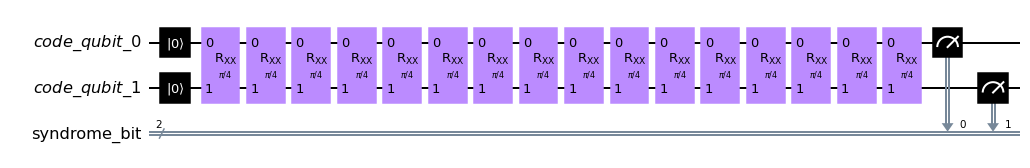

In [5]:
qc.draw(output='mpl')

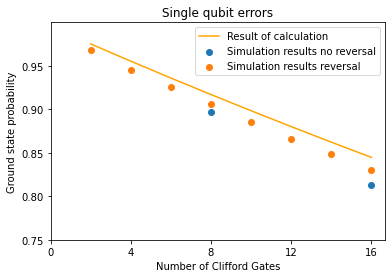

In [6]:
#graph constants
YMIN = 0.75
YMAX = 1.000
YTICK = 0.05

#graph
title_text = "Ground state probabilty against number of Clifford Gates"
plt.scatter(gate_depth_plot_no_reverse, simulation_probability_no_reverse, label = "Simulation results no reversal" )
plt.scatter(gate_depth_plot_reverse, simulation_probability_reverse, label = "Simulation results reversal" )
#plt.plot(gate_depth_plot_no_reverse, theoretical_probability_no_reverse, label = "Result of calculation" , color="orange")
plt.plot(gate_depth_plot_reverse, theoretical_probability_reverse, label = "Result of calculation" , color="orange")
plt.title('Single qubit errors')
plt.xlabel('Number of Clifford Gates')
plt.ylabel('Ground state probability')  
plt.legend()
plt.ylim(YMIN, YMAX)
plt.xticks(np.arange(0, 20, 4))
plt.yticks(np.arange(YMIN, YMAX, YTICK))
fname = "single_qubit_errors.png"
plt.savefig(fname)